# Predição de Preços de Imóveis

Este projeto tem como objetivo prever os preços de Imóveis utilizando algoritmos de aprendizado de máquina. O conjunto de dados utilizado para este projeto foi coletado (scraped) do Vivareal: o foco deste trabalho é prever o preço de venda das casas utilizando Técnicas de Regressão. O conjunto de dados contém informações sobre casas em Goiânia, incluindo suas características e preços de venda. O projeto envolve pré-processamento de dados, engenharia de atributos (feature engineering), treinamento de modelos e avaliação. O objetivo é construir um modelo capaz de prever com precisão o preço de venda de uma casa com base em suas características.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import RFE

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    cross_validate,
)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
df = pd.read_csv("/content/drive/MyDrive/ML_WORK/dataset_houses.csv", sep=",", encoding="utf-8")

"O dataset apresenta valores atípicos (outliers) que devem ser tratados. Na coluna 'tipo_de_negócio', o conjunto de dados está categorizado em 'Venda' e 'Aluguel'. Iremos aplicar um filtro para selecionar apenas os registros de 'Venda', isolando assim todos os imóveis disponíveis para comercialização.


In [5]:
# Restrição

df["is_property"] = df["titulo"].str.contains("Casa|Apartamento", case=False) | \
    df["descricao"].str.contains("Casa|Apartamento", case=False)

df = df[df["is_property"]].copy()

In [6]:
df.shape

(5367, 25)

In [7]:
df.head()

,titulo,endereco,descricao,preco,condominio,iptu,area,quartos,banheiros,suites,...,link,data_coleta,fonte,pagina_busca,id_imovel,data_criacao,dias_desde_criacao,bairro,regiao,is_property
0,"Casa com 3 Quartos e 2 banheiros à Venda, 95 m...","Rua 27 de Setembro, 1 - Setor Estrela Dalva, G...",CASA NO SETOR DALVA EM GOIÂNIA-GOIASSala e Coz...,299000,-1,-1,95,3,2,1,...,https://www.vivareal.com.br/imovel/casa-3-quar...,2025-06-20T03:52:33.779958,vivareal.com.br,pagina_0,2.772555e+09,20-01-2025,150,Setor Estrela Dalva,NOROESTE,True
1,"Casa com 2 Quartos e 2 banheiros à Venda, 63 m...","Rua 18 de Outubro, 9 - Setor Estrela Dalva, Go...",* 2Q. sendo 1 suíte* Sala de TV/Jantar* Cozinh...,284000,-1,-1,63,2,2,1,...,https://www.vivareal.com.br/imovel/casa-2-quar...,2025-06-20T03:52:41.667019,vivareal.com.br,pagina_0,2.814482e+09,16-06-2025,3,Setor Estrela Dalva,NOROESTE,True
2,"Casa com 3 Quartos e 2 banheiros à Venda, 138 ...","Rua ED5, 2 - Setor Estrela Dalva, Goiânia - GO",LINDA CASA LOCALIZADA NO SETOR ESTRELA DALVA.....,350000,-1,400,138,3,2,2,...,https://www.vivareal.com.br/imovel/casa-3-quar...,2025-06-20T03:52:49.778316,vivareal.com.br,pagina_0,2.814013e+09,13-06-2025,6,Setor Estrela Dalva,NOROESTE,True
3,"Casa com 2 Quartos e 1 banheiro à Venda, 64 m²...","Rua João Paulo, 0 - Setor Estrela Dalva, Goiân...",Fale direto com o captador:Daterra Imóveis - ...,280000,-1,-1,64,2,1,1,...,https://www.vivareal.com.br/imovel/casa-2-quar...,2025-06-20T03:52:58.436292,vivareal.com.br,pagina_0,2.812884e+09,10-06-2025,9,Setor Estrela Dalva,NOROESTE,True
4,"Casa com 2 Quartos e 2 banheiros à Venda, 62 m...","Rua 19 de Novembro, casa 02 - Setor Estrela Da...",CASA À VENDA NO ESTRELA DALVA – 2 QUARTOS (1 S...,220000,1,233,62,2,2,1,...,https://www.vivareal.com.br/imovel/casa-2-quar...,2025-06-20T03:53:07.610261,vivareal.com.br,pagina_0,2.811583e+09,05-06-2025,14,Setor Estrela Dalva,NOROESTE,True


In [8]:
# Restrição

df = df[
    (df["tipo_de_negocio"] == "Venda") & (df["preco"] > 0) & (df["area"] > 0)
].copy()

In [9]:
print("Shape depois de filtrar Venda e preco > 0:", df.shape)

Shape depois de filtrar Venda e preco > 0: (4857, 25)


In [10]:
# Para os valores nulos o scraping tratou como -1, converter -1 para valores NaN

cols_neg_1 = [
    "preco",
    "condominio",
    "iptu",
    "area",
    "quartos",
    "banheiros",
    "suites",
    "andar",
    "vagas_de_estacionamento",
    "dias_desde_criacao",
]

for col in cols_neg_1:
    if col in df.columns:
        df[col] = df[col].replace(-1, np.nan)

df = df[~df["preco"].isna()].copy()

In [11]:
# Considerando que Imovéis de locação, espaços, etc. Sao espaços que não existe quartos em sua descrição.
# Serão considerados imóveis não residenciais. Existe ainda a possibilidade de erro ao cadastrar o imóvel e não colocar a quantidade de quartos

# --- Remover imóveis não residenciais ---
df = df[df["quartos"].notna()].copy()

# Para ser considerado imóvel residêncial, deve existir pelo menos um quarto
df = df[df["quartos"] > 0].copy()

# --- Remover áreas irreais (erro de scraping) ---
# Área mínima realista para imóveis residenciais: ≥ 20 m²
# Área máxima realista: ≤ 1000 m²
df = df[df["area"].between(20, 1000)].copy()

# Para a construção do modelo, foi estabelecido algumas restrições.

In [12]:
df.shape

(4588, 25)

O foco é exclusivamente em imóveis À VENDA, então podemos ser ainda mais agressivos e eficientes na escolha das features, removendo o ruído do scraping.


In [13]:
# Removendo as colunas que não são relevantes para o treinamento do nosso modelo.

cols_to_drop = [
    "titulo",
    "endereco",
    "descricao",
    "link",
    "ofertante",
    "fonte",
    "pagina_busca",
    "id_imovel",
    "data_coleta",
    "data_cadastro",
    "data_criacao",
    "tipo_de_negocio",
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

print("Colunas após drop:", df.columns.tolist())

Colunas após drop: ['preco', 'condominio', 'iptu', 'area', 'quartos', 'banheiros', 'suites', 'andar', 'vagas_de_estacionamento', 'dias_desde_criacao', 'bairro', 'regiao', 'is_property']


In [14]:
df.columns

Index(['preco', 'condominio', 'iptu', 'area', 'quartos', 'banheiros', 'suites',
       'andar', 'vagas_de_estacionamento', 'dias_desde_criacao', 'bairro',
       'regiao', 'is_property'],
      dtype='object')

![boxplot](https://encrypted-tbn3.gstatic.com/licensed-image?q=tbn:ANd9GcRxEKWG-lXUjVTJz2P1wj7rw29jnK4Ifx5UbEbYl7YviCUrOvALY5LI0Yac83N_Pm3DORZAEsARjPWGbHNO7NQfwdkTwy93llZey86bl4IUbs3U0Zk)


Em estatística o padrão do Boxplot, usamos os quartis 0.25 (25%) e 0.75 (75%). Se usássemos o padrão em imóveis, o modelo consideraria qualquer casa de luxo como um "erro" (outlier) e a removeria. No código, alteramos os limites para 5% (0.05) e 95% (0.95), deixando os limites inferiores e superiores mais soft, removendo dados que são muito discrepantes como imóveis cadastrados por 1 Real ou 100.00 Reais ou imóveis cadastrados por R$ 999.999.999. Pegando os valores extremos,


Text(0, 0.5, 'Metros Quadrados (m²)')

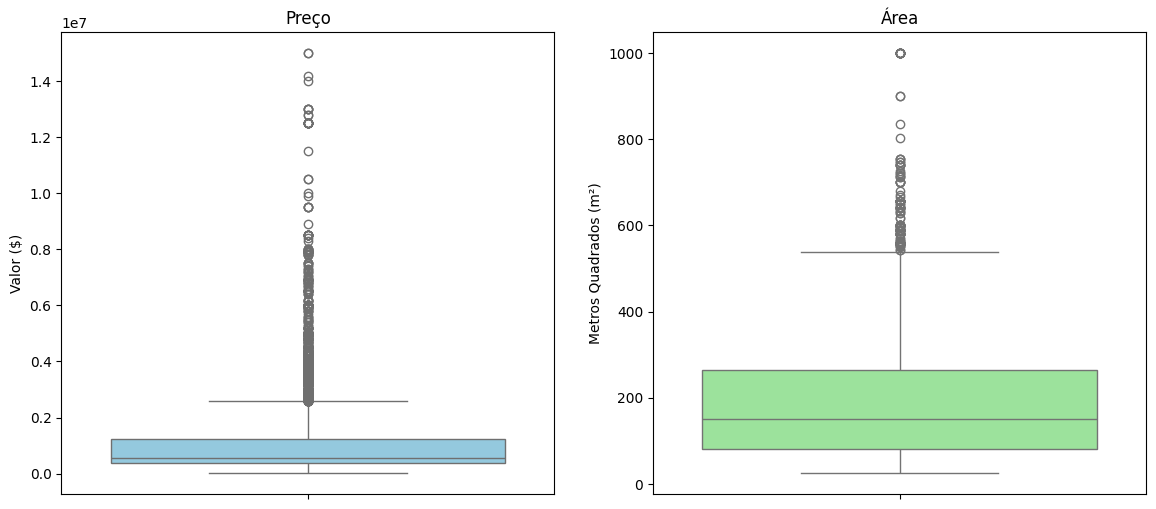

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Preço
sns.boxplot(y=df["preco"], ax=ax[0], color="skyblue")
ax[0].set_title("Preço")
ax[0].set_ylabel("Valor ($)")

# Plot Área
sns.boxplot(y=df["area"], ax=ax[1], color="lightgreen")
ax[1].set_title("Área")
ax[1].set_ylabel("Metros Quadrados (m²)")

In [16]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = max(lower_bound, 0)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


df = remove_outliers(df, "preco")
df = remove_outliers(df, "area")

In [17]:
print(f"Shape após remoção de outliers: {df.shape}")

Shape após remoção de outliers: (4566, 13)


In [18]:
print("\nValores nulos:")
print(df.isnull().sum())


Valores nulos:
preco                         0
condominio                 2648
iptu                       2572
area                          0
quartos                       0
banheiros                     0
suites                        0
andar                      3875
vagas_de_estacionamento       0
dias_desde_criacao            0
bairro                        0
regiao                        0
is_property                   0
dtype: int64


As variáveis “Condomínio”, “IPTU” e “andar” apresentam muitos valores ausentes (NaN), além de colunas praticamente sem preenchimento. Como o IPTU pode estar fortemente relacionado ao valor do imóvel, mantê-la poderia introduzir alta colinearidade no modelo, o que não é desejável.

Já a variável “andar”, no caso de apartamentos, e a indicação de sobrado para casas, não apresentou impacto significativo na análise exploratória, mostrando baixa relevância preditiva.

Diante disso, opto por remover essas variáveis do conjunto de dados utilizado para o modelo preditivo.

In [19]:
col_to_remove = ["condominio", "iptu", "andar", "dias_desde_criacao", "is_property"]
df = df.drop(columns=[c for c in col_to_remove if c in df.columns], axis=1)

In [20]:
print("\nValores nulos:")
print(df.isnull().sum())


Valores nulos:
preco                      0
area                       0
quartos                    0
banheiros                  0
suites                     0
vagas_de_estacionamento    0
bairro                     0
regiao                     0
dtype: int64


Text(0.5, 1.0, 'Área vs Quartos')

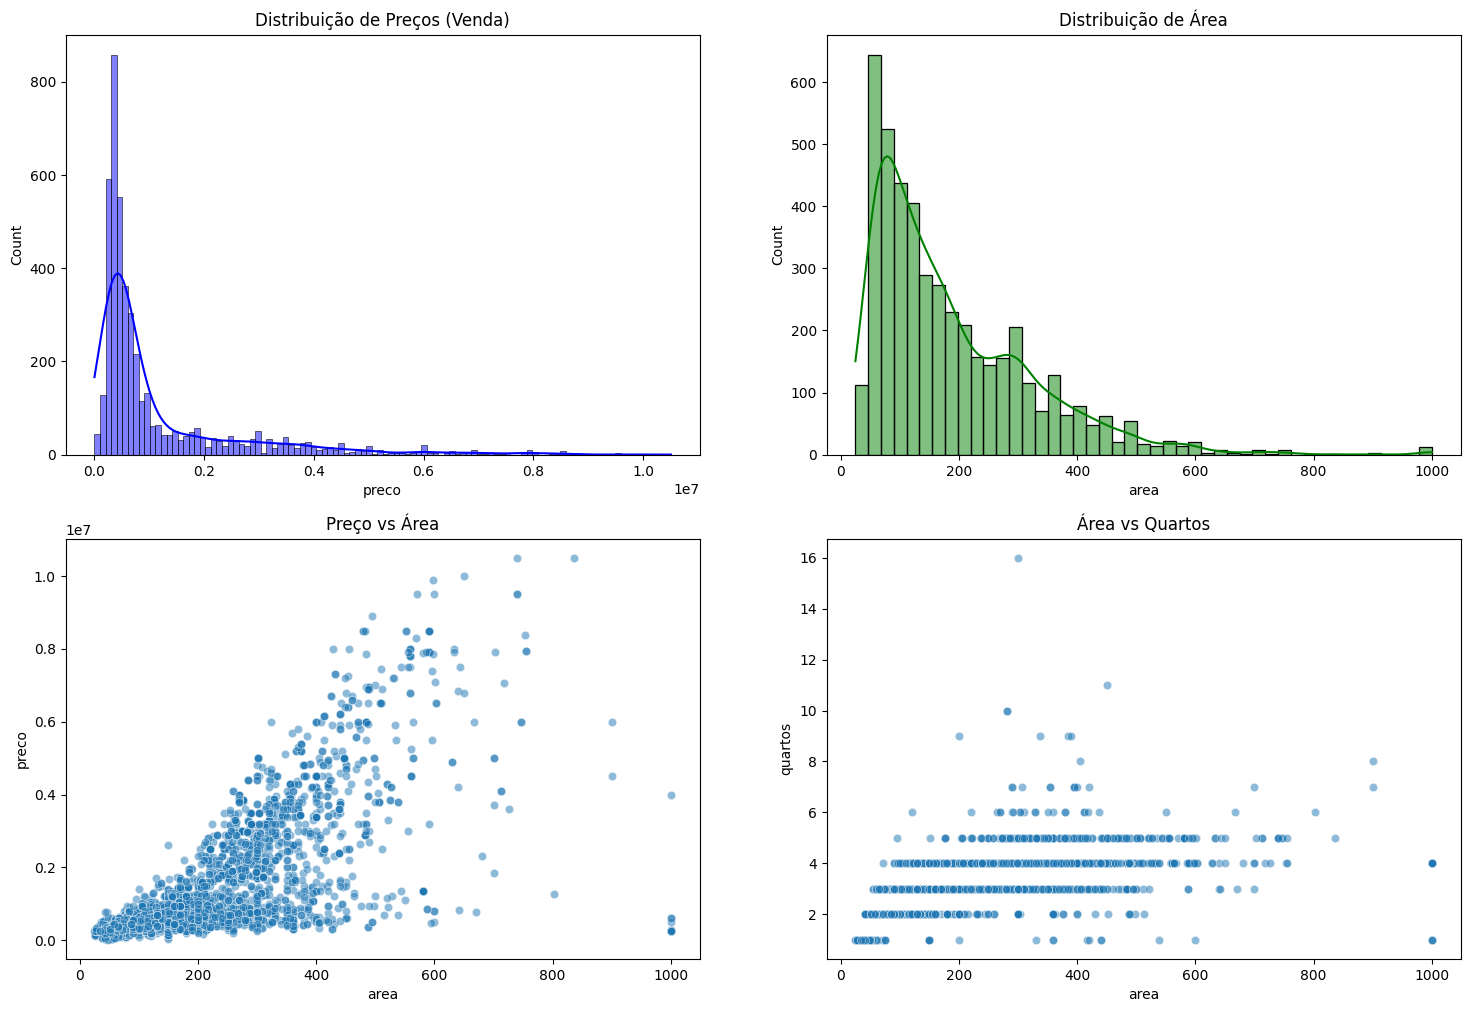

In [21]:
# Visualizações EDA
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Dist do Preço
sns.histplot(df["preco"], kde=True, ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Distribuição de Preços (Venda)")

# Dist da Área
sns.histplot(df["area"], kde=True, ax=axes[0, 1], color="green")
axes[0, 1].set_title("Distribuição de Área")

# Scatter Preço x Área
sns.scatterplot(data=df, x="area", y="preco", alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title("Preço vs Área")

# Preço por Bairro (Top 10)
sns.scatterplot(data=df, x="area", y="quartos", alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title("Área vs Quartos")

In [22]:
# Restrição
df = df[df["quartos"] < 10]

In [23]:
df.shape

(4562, 8)

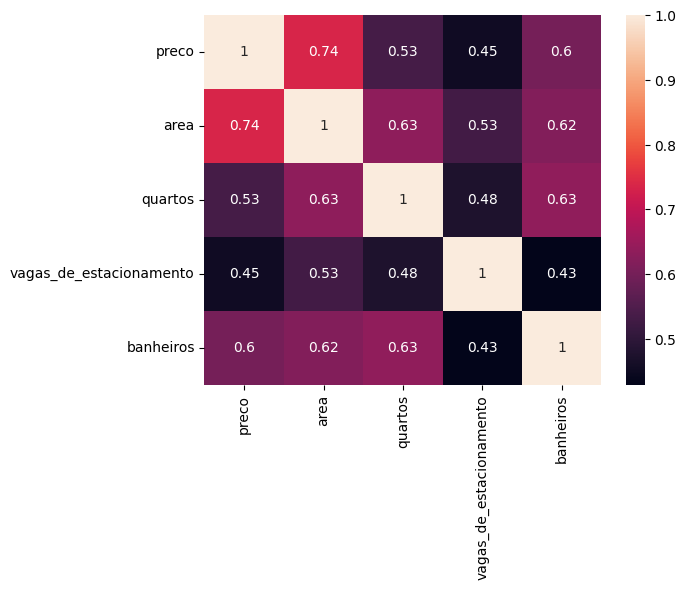

In [24]:
corr = df[
    [
        "preco",
        "area",
        "quartos",
        "vagas_de_estacionamento",
        "banheiros",
    ]
].corr()
sns.heatmap(corr, annot=True)
plt.show()

# Modelos


## Funções


In [25]:
def plotar_learningcurve(modelo, X, y, cv=5, scoring="neg_mean_squared_error"):
    train_sizes, train_scores, test_scores = learning_curve(
        modelo,
        X,
        y,
        cv=5,
        scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 20),
    )

    # train_sizes - quantidade de dados de treinamento
    # train_scores - erro de treinamento
    # test_scores - erro de validação
    # scoring="neg_mean_squared_error" - erro negativo de mse (padrão do sklearn)
    # train_sizes=np.linspace(0.1, 1.0, 20) - quantidade de dados de treinamento (de 10% a 100% com 20 passos) Isso cria um array com 20 valores igualmente espaçados entre 0.1 e 1.0 (incluindo ambos os extremos).
    # cv=5 - quantidade de folds

    # Convertendo erros negativos para valores positivos de MSE
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    # Plotando as curvas de aprendizado
    plt.figure(figsize=(10, 6))
    plt.plot(
        train_sizes,
        train_scores_mean,
        label="Erro de treinamento",
        color="blue",
        marker="o",
    )
    plt.plot(
        train_sizes,
        test_scores_mean,
        label="Erro de validação",
        color="green",
        marker="o",
    )
    plt.title("Curva de Aprendizado")
    plt.xlabel("Tamanho do conjunto de Treinamento")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
def validacao_cruzada(modelo, X, y, cv=5):
    # Iniciando o K-fold com embaralhamento
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    # n_splits=cv - quantidade de folds
    # shuffle=True - embaralhar os dados
    # random_state=42 - seed para reprodutibilidade

    # Configurando nossas métricas
    scoring = {"mse": make_scorer(mean_squared_error), "r2": make_scorer(r2_score)}

    # Realizando validação cruzada e obtendo métricas
    metricas = cross_validate(
        modelo, X, y, cv=kf, scoring=scoring, return_train_score=True
    )

    # Exibindo métricas
    print("Métricas de treinamento:")
    print(
        "Mean Squared Error (MSE):",
        f"{metricas['train_mse'].mean():.4f} ± {metricas['train_mse'].std():.4f}",
    )
    print(
        "R2 Score:",
        f"{metricas['train_r2'].mean():.4f} ± {metricas['train_r2'].std():.4f}",
    )

    print("Métricas de teste:")
    print(
        "Mean Squared Error (MSE):",
        f"{metricas['test_mse'].mean():.4f} ± {metricas['test_mse'].std():.4f}",
    )
    print(
        "R2 Score:",
        f"{metricas['test_r2'].mean():.4f} ± {metricas['test_r2'].std():.4f}",
    )

## Colunas

In [27]:
df.columns

Index(['preco', 'area', 'quartos', 'banheiros', 'suites',
       'vagas_de_estacionamento', 'bairro', 'regiao'],
      dtype='object')

In [28]:
df = df.rename(columns={"vagas_de_estacionamento": "garagem"})

In [29]:
num_features = [
    "area",
    "quartos",
    "banheiros",
    "suites",
    "garagem",
]

cat_features = ["bairro", "regiao"]

business_features = [
    "area",
    "quartos",
    "banheiros",
]

## Regressão Linear

In [30]:
# 1. PRIMEIRA TENTATIVA - Regressão linear com variváveis categóricas

transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ],
    remainder="passthrough" # Deixe passar todas as colunas que não são categóricas, sem transformação.
)

pipeline = Pipeline(steps=[
    ("prep", transformer),
    ("reg", LinearRegression())
])

X = df[num_features+cat_features].copy()
y = df["preco"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

pipeline.fit(X_train, y_train)

print("R² treino:", r2_score(y_train, pipeline.predict(X_train)))
print("R² teste:", r2_score(y_test, pipeline.predict(X_test)))


R² treino: 0.834057227666806
R² teste: 0.8251720912630277


In [31]:
# 1.1 PRIMEIRA TENTATIVA - Regressão linear sem variváveis categóricas

X = df[num_features].copy()
y = df["preco"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

print("r2 - treino", r2_score(y_train, reg_linear.predict(X_train)))
print("r2 - teste", r2_score(y_test, reg_linear.predict(X_test)))

r2 - treino 0.6688057780694072
r2 - teste 0.6625834334448952


In [ ]:
X = df[num_features]
y = df["preco"]

reg_linear = LinearRegression()
selector = RFE(reg_linear, n_features_to_select=5)
# RFE (Recursive Feature Elimination) - Eliminação Recursiva de Features
# Treina a Regressão Linear com todas as features
# Remove a feature com menor importância
# Retreina com features
# Repete até restar apenas 5 features (n_features_to_select=5)
selector.fit(X, y)

print("Features selecionadas:", X.columns[selector.support_])
print("Features não selecionadas:", X.columns[~selector.support_])

Features selecionadas: Index(['area', 'quartos', 'banheiros', 'suites', 'garagem'], dtype='object')
Features não selecionadas: Index([], dtype='object')


In [ ]:
# 1.2 PRIMEIRA TENTATIVA - Regressão Linear com Validação Cruzada sem variáveis categóricas

X = df[num_features]
print("Colunas selecionadas:", X.columns)

# X é a minha variável independente (features) e y é a variável dependente (target)

reg_linear = LinearRegression()

validacao_cruzada(reg_linear, X, y, cv=5)

Colunas selecionadas: Index(['area', 'quartos', 'banheiros', 'suites', 'garagem'], dtype='object')
Métricas de treinamento:
Mean Squared Error (MSE): 740241987325.9158 ± 17020547744.5914
R2 Score: 0.6682 ± 0.0036
Métricas de teste:
Mean Squared Error (MSE): 749328991207.8878 ± 71101711701.5646
R2 Score: 0.6637 ± 0.0143


In [ ]:
# 1.3 PRIMEIRA TENTATIVA- Regressão Linear com Validação Cruzada com variáveis categóricas

X = df[num_features+cat_features].copy()
y = df["preco"]

validacao_cruzada(pipeline, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 368676042136.0284 ± 10489252459.0874
R2 Score: 0.8347 ± 0.0042
Métricas de teste:
Mean Squared Error (MSE): 399166367552.0329 ± 42372250692.3483
R2 Score: 0.8204 ± 0.0159


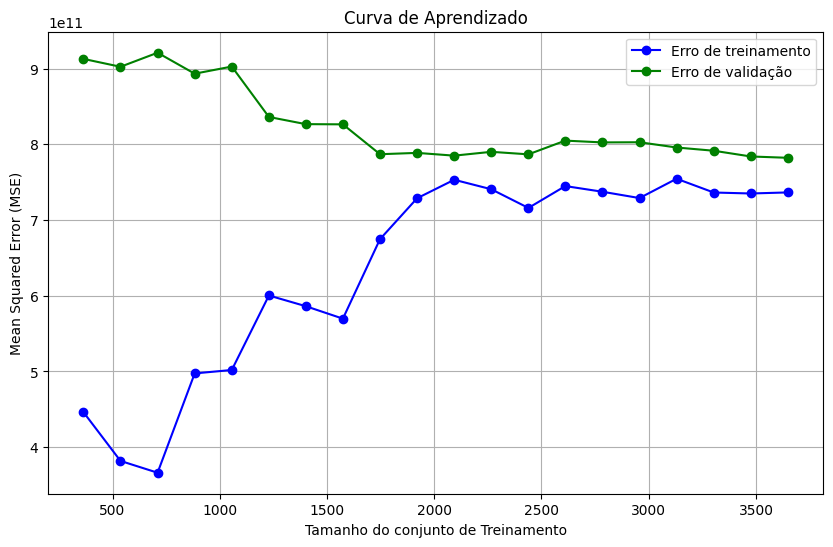

In [ ]:
X = df[num_features] # Sem variáveis categóricas

plotar_learningcurve(reg_linear, X, y, cv=5, scoring="r2")

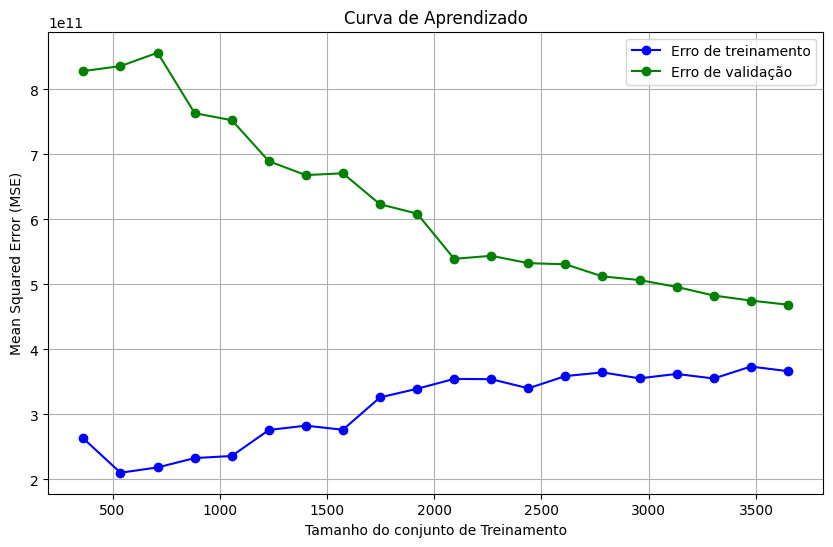

In [ ]:
X = df[num_features+cat_features] # Com variáveis categóricas

plotar_learningcurve(pipeline, X, y, cv=5, scoring="r2")

## Regressão Polinomial

In [ ]:
X = df[num_features]
y = df["preco"]

pipeline_square = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("rfe", RFE(LinearRegression(), n_features_to_select=5)),
        ("regressor", LinearRegression()),
    ]
)

pipeline_square.fit(X, y)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=5)),
                ('regressor', LinearRegression())])

In [ ]:
# Gerar nomes das features polinomias
poly_features = pipeline_square.named_steps["poly"]
print("Poly features:", poly_features)
feature_names = poly_features.get_feature_names_out()
# print("Feature names:", feature_names)

print("===" * 10)
# Features escolhidas pelo RFE
rfe = pipeline_square.named_steps["rfe"]
selected_features = feature_names[rfe.support_]

print("Features selecionadas pelo RFE")
for k, v in enumerate(selected_features):
    print(k, v)

Poly features: PolynomialFeatures()
Features selecionadas pelo RFE
0 quartos
1 banheiros
2 suites
3 quartos banheiros
4 suites^2


In [ ]:
# 1. SEGUNDA TENTATIVA - Regressão polinomial de segundo grau com variáveis categóricas

pipeline_poly = Pipeline(steps=[
    ("prep", transformer),
    ("poly", make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression()))
])

X = df[num_features+cat_features].copy()
y = df["preco"]

validacao_cruzada(pipeline_poly, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 214176866492.4919 ± 6010324678.2385
R2 Score: 0.9040 ± 0.0026
Métricas de teste:
Mean Squared Error (MSE): 273399542789.0379 ± 43361575286.2521
R2 Score: 0.8775 ± 0.0150


In [ ]:
# 1.1 SEGUNDA TENTATIVA - Regressão polinomial de segundo grau sem variáveis categóricas

X = df[num_features].copy()

reg_quadrada = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

validacao_cruzada(reg_quadrada, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 472827658802.9645 ± 20423761610.0967
R2 Score: 0.7880 ± 0.0091
Métricas de teste:
Mean Squared Error (MSE): 496967442212.8724 ± 88122532119.0433
R2 Score: 0.7764 ± 0.0366


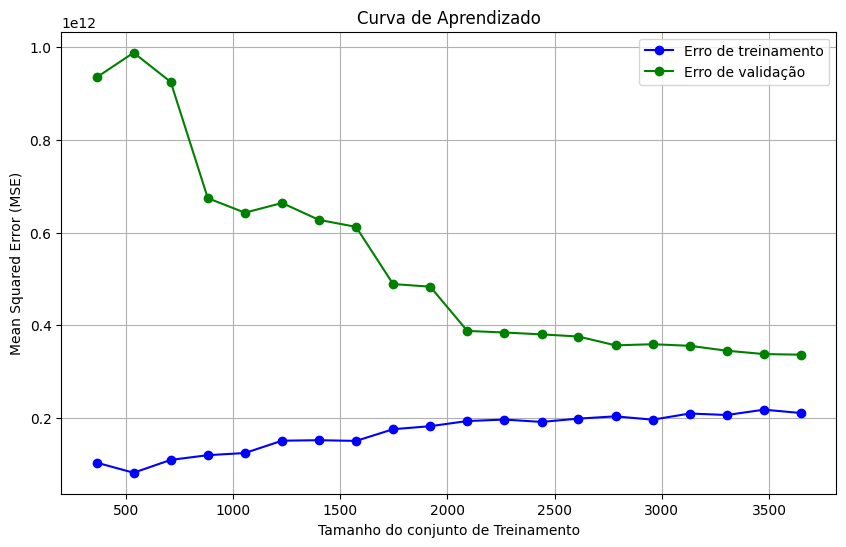

In [ ]:
# Com variáveis categóricas
X = df[num_features+cat_features].copy()
plotar_learningcurve(pipeline_poly, X, y, cv=5, scoring="r2")

## Árvore de Decisão para regressão

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# 1 TERCEIRA TENTATIVA - Árvore de decisão para regresão sem variáveis categóricas

X = df[num_features]
y = df["preco"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg_dtr = DecisionTreeRegressor(max_depth=7)
validacao_cruzada(reg_dtr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 278880843509.8573 ± 19356897862.9541
R2 Score: 0.8749 ± 0.0090
Métricas de teste:
Mean Squared Error (MSE): 463878865801.5065 ± 79023836293.7985
R2 Score: 0.7910 ± 0.0339


In [ ]:
# 1.1 TERCEIRA TENTATIVA - Árvore de decisão para regresão com variáveis categóricas

pipeline_dt = Pipeline(steps=[
    ("prep", transformer),
    ("dt", DecisionTreeRegressor(max_depth=7))
])

X = df[num_features+cat_features].copy()
y = df["preco"]

validacao_cruzada(pipeline_dt, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 192630788594.0908 ± 7796420912.0490
R2 Score: 0.9136 ± 0.0050
Métricas de teste:
Mean Squared Error (MSE): 356254051952.5210 ± 37686439262.0882
R2 Score: 0.8390 ± 0.0208


## Pesquisa em Grade - Grid Seach

In [ ]:
from sklearn.model_selection import GridSearchCV

ajustes de hiperparâmetros

In [ ]:
parametros = {
    "max_depth": [3, 5, 7, 9],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

reg_dtr = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    reg_dtr, parametros, cv=5, scoring="r2", return_train_score=True
)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='r2')

In [ ]:
print("Melhor configuração de hiperparâmetros:", grid_search.best_params_)

Melhor configuração de hiperparâmetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [ ]:
# 1 QUARTA TENTATIVA - Árvore de decisão com GridSearch (Hiperparamêtros)
X = df[num_features].copy()
y = df["preco"]

reg_dtr = DecisionTreeRegressor(max_depth=7, min_samples_leaf=2, min_samples_split=2)
validacao_cruzada(reg_dtr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 291288513947.2120 ± 18408318799.8876
R2 Score: 0.8694 ± 0.0083
Métricas de teste:
Mean Squared Error (MSE): 466254900551.8213 ± 78510281921.1444
R2 Score: 0.7905 ± 0.0308


In [ ]:
# 1.1 QUARTA TENTATIVA - Árvore de decisão com GridSearch (Hiperparamêtros) e feat. Categóricas

pipeline_dtr_gridsearch = Pipeline(steps=[
    ("prep", transformer),
    ("dtr", DecisionTreeRegressor(max_depth=7, min_samples_leaf=2, min_samples_split=2))
])

X = df[num_features+cat_features].copy()
y = df["preco"]

validacao_cruzada(pipeline_dtr_gridsearch, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 198578899303.0116 ± 8101331584.2049
R2 Score: 0.9109 ± 0.0051
Métricas de teste:
Mean Squared Error (MSE): 350671832039.4623 ± 32715303187.6547
R2 Score: 0.8416 ± 0.0186


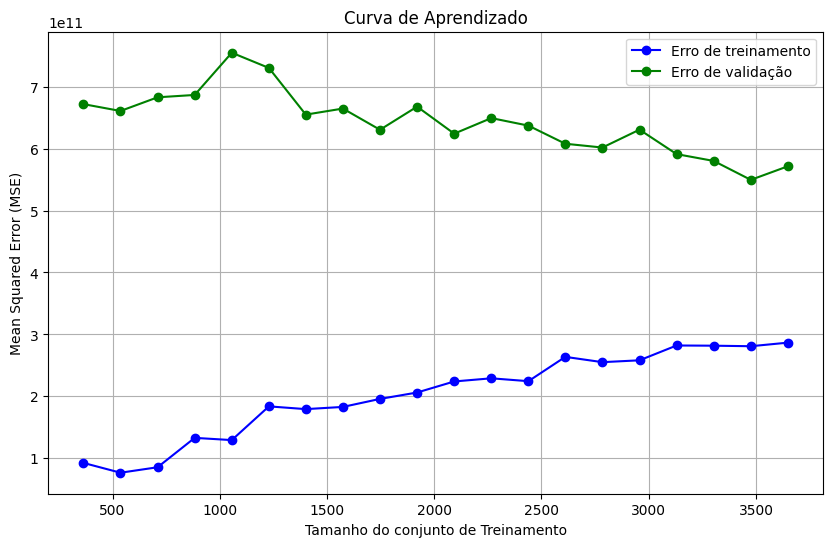

In [ ]:
plotar_learningcurve(reg_dtr, X, y, cv=5, scoring="r2")

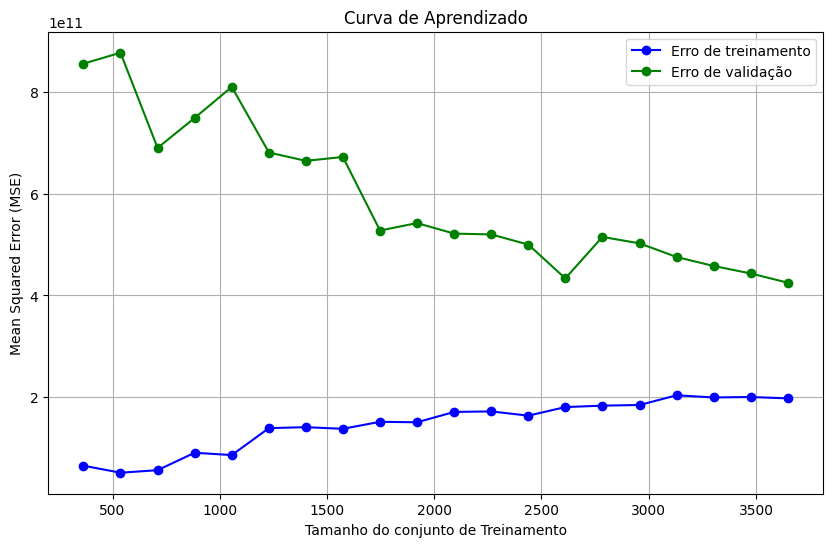

In [ ]:
plotar_learningcurve(pipeline_dtr_gridsearch, X, y, cv=5, scoring="r2")

In [ ]:
df_grid = pd.DataFrame(grid_search.cv_results_)
df_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004531,0.001106,0.001951,0.000272,3,1,2,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.711858,0.792508,...,0.701615,0.079485,16,0.776617,0.751811,0.77978,0.790794,0.777572,0.775315,0.012797
1,0.003850,0.000207,0.001680,0.000034,3,1,5,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.711858,0.792508,...,0.701615,0.079485,16,0.776617,0.751811,0.77978,0.790794,0.777572,0.775315,0.012797
2,0.003836,0.000156,0.001887,0.000408,3,1,10,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.711858,0.792508,...,0.701615,0.079485,16,0.776617,0.751811,0.77978,0.790794,0.777572,0.775315,0.012797
3,0.005851,0.000284,0.002930,0.000244,3,2,2,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.711858,0.792508,...,0.701615,0.079485,16,0.776617,0.751811,0.77978,0.790794,0.777572,0.775315,0.012797
4,0.005825,0.001002,0.002514,0.000173,3,2,5,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.711858,0.792508,...,0.701615,0.079485,16,0.776617,0.751811,0.77978,0.790794,0.777572,0.775315,0.012797


In [ ]:
df_grid = df_grid[["params", "mean_train_score", "mean_test_score"]].copy()
df_grid["dif_score"] = df_grid["mean_train_score"] - df_grid["mean_test_score"]

In [ ]:
df_grid[df_grid["dif_score"] < 0.1].sort_values(by="dif_score", ascending=False)

,params,mean_train_score,mean_test_score,dif_score
11,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.833042,0.733474,0.099568
10,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.833114,0.734685,0.098429
0,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.775315,0.701615,0.073700
2,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.775315,0.701615,0.073700
1,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.775315,0.701615,0.073700
3,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.775315,0.701615,0.073700
4,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.775315,0.701615,0.073700
6,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s...",0.775315,0.701615,0.073700
5,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.775315,0.701615,0.073700
8,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s...",0.775315,0.701615,0.073700


10	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}	0.8331144734029877	0.7346849964306301	0.0984294769723576

## Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
# 1 QUINTA TENTATIVA - Random Forest sem variáveis categóricas

X = df[num_features]

reg_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
validacao_cruzada(reg_rfr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 60752984500.4149 ± 2834337177.6945
R2 Score: 0.9727 ± 0.0017
Métricas de teste:
Mean Squared Error (MSE): 345498327691.5369 ± 66668144696.1616
R2 Score: 0.8444 ± 0.0284


In [ ]:
# 1.1 QUINTA TENTATIVA - Random Forest sem variáveis categóricas

pipeline_rfr = Pipeline(steps=[
    ("prep", transformer),
    ("dtr", RandomForestRegressor(n_estimators=100, random_state=42))
])

X = df[num_features+cat_features].copy()

validacao_cruzada(pipeline_rfr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 32041234329.1645 ± 1384828452.9012
R2 Score: 0.9856 ± 0.0009
Métricas de teste:
Mean Squared Error (MSE): 216417910323.1198 ± 32853193766.9270
R2 Score: 0.9023 ± 0.0155


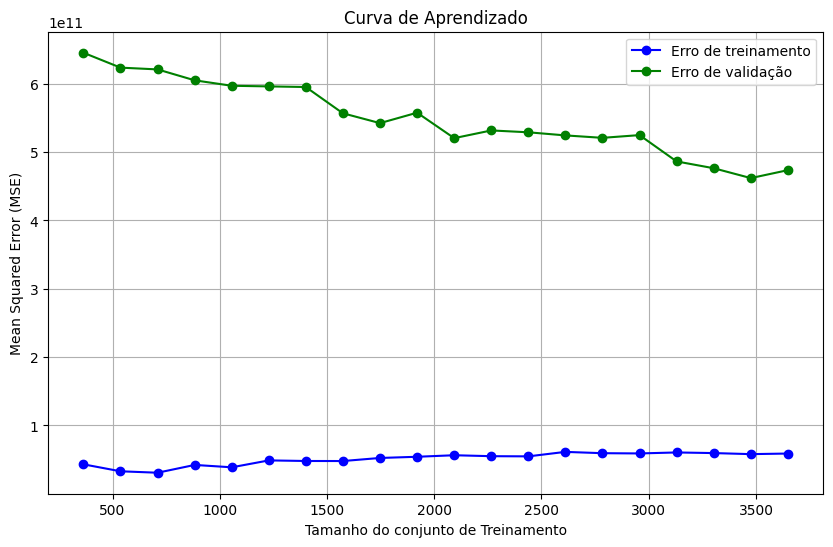

In [34]:
# Random Forest sem variáveis categóricas

plotar_learningcurve(reg_rfr, X, y, cv=5)

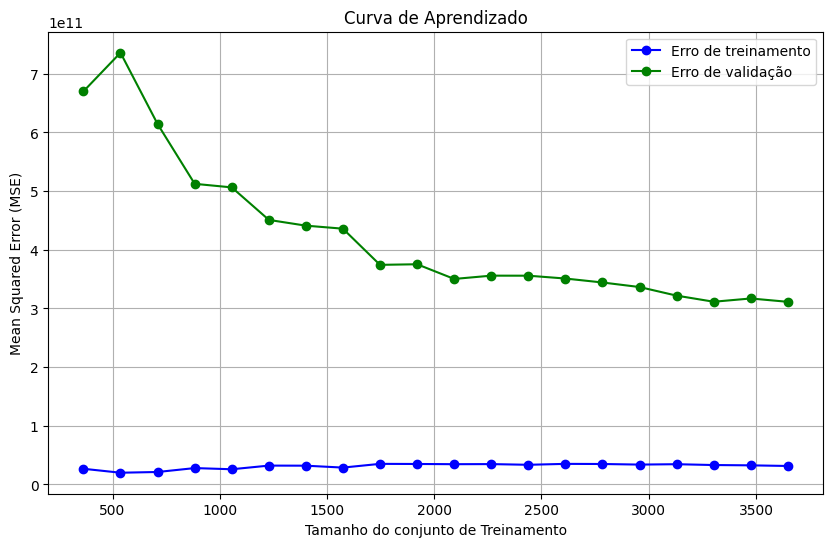

In [ ]:
# Random Forest com variáveis categóricas

plotar_learningcurve(pipeline_rfr, X, y, cv=5)

In [35]:
parametros = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

reg_rfr = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    reg_rfr, parametros, cv=5, scoring="r2", return_train_score=True
)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='r2')

In [36]:
print("Melhor configuração de hiperparâmetros:", grid_search.best_params_)

Melhor configuração de hiperparâmetros: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [37]:
reg_rfr = RandomForestRegressor(
    max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=100
)
validacao_cruzada(reg_rfr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 277030373351.4064 ± 12734727677.1576
R2 Score: 0.8758 ± 0.0062
Métricas de teste:
Mean Squared Error (MSE): 390801189200.7849 ± 56708894051.1865
R2 Score: 0.8239 ± 0.0251


In [38]:
df_grid = pd.DataFrame(grid_search.cv_results_)
df_grid = df_grid[["params", "mean_train_score", "mean_test_score"]].copy()
df_grid["dif_score"] = df_grid["mean_train_score"] - df_grid["mean_test_score"]

In [39]:
df_grid[df_grid["dif_score"] < 0.05]

,params,mean_train_score,mean_test_score,dif_score


In [40]:
df_grid.sort_values(by="dif_score", ascending=False)

,params,mean_train_score,mean_test_score,dif_score
56,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.894959,0.758881,0.136078
55,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.894560,0.759162,0.135398
65,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",0.888622,0.754750,0.133872
54,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.894510,0.760766,0.133744
59,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.890968,0.757626,0.133342
...,...,...,...,...
0,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.794145,0.722264,0.071881
6,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.794145,0.722264,0.071881
15,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.794124,0.722382,0.071742
9,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.794124,0.722382,0.071742


## GradientBoostingRegressor

In [ ]:
!pip install xgboost
!pip install --upgrade pip

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
# 1 SEXTA TENTATIVA - Random Forest sem variáveis categóricas

reg_gbr = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
)
validacao_cruzada(reg_gbr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 408068855633.2611 ± 10363446270.1951
R2 Score: 0.8170 ± 0.0055
Métricas de teste:
Mean Squared Error (MSE): 449488646235.8146 ± 44336452190.1636
R2 Score: 0.7971 ± 0.0231


In [49]:
# 1.1 SEXTA TENTATIVA - Random Forest com variáveis categóricas

pipeline_gbr = Pipeline(steps=[
    ("prep", transformer),
    ("xbr", GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
)
    )
])

X = df[num_features+cat_features].copy()

validacao_cruzada(pipeline_gbr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 320447260915.2843 ± 6475994822.5954
R2 Score: 0.8563 ± 0.0042
Métricas de teste:
Mean Squared Error (MSE): 357439438576.4404 ± 38887202385.3131
R2 Score: 0.8381 ± 0.0235


## XGBRegressor

In [46]:
from xgboost import XGBRegressor

In [51]:
# 1 SÉTIMA TENTATIVA - Random Forest sem variáveis categóricas

X = df[num_features]

reg_xbr = XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2, random_state=42)

validacao_cruzada(reg_xbr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 416431040102.4000 ± 10473837309.8369
R2 Score: 0.8132 ± 0.0059
Métricas de teste:
Mean Squared Error (MSE): 456281299353.6000 ± 45772743897.3912
R2 Score: 0.7941 ± 0.0229


In [53]:
# 1.1 SÉTIMA TENTATIVA - Random Forest com variáveis categóricas

pipeline_xbgr = Pipeline(steps=[
    ("prep", transformer),
    ("xbr", XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=2, random_state=42)
    )
])

X = df[num_features+cat_features].copy()


validacao_cruzada(pipeline_xbgr, X, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 325487335833.6000 ± 8191925832.1117
R2 Score: 0.8540 ± 0.0048
Métricas de teste:
Mean Squared Error (MSE): 366705187225.6000 ± 37005383785.1960
R2 Score: 0.8341 ± 0.0222


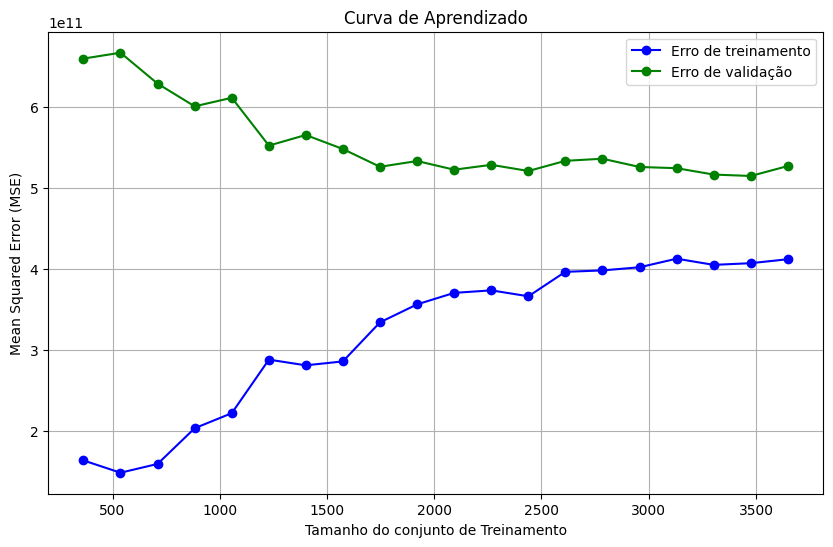

In [52]:
plotar_learningcurve(reg_xbr, X, y, cv=5)

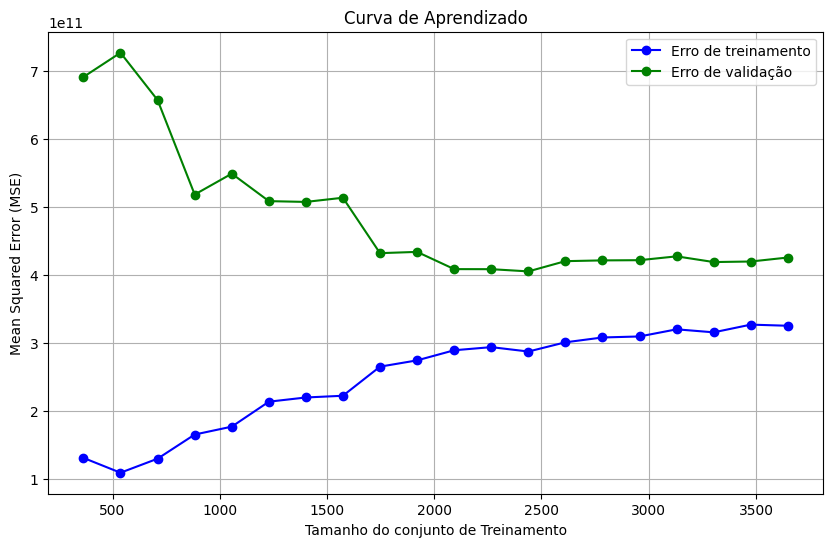

In [54]:
plotar_learningcurve(pipeline_xbgr, X, y, cv=5)

In [70]:
# Modelo baseline com todas as features
pipeline_gbr = Pipeline(steps=[
    ("prep", transformer),
    ("gbr", GradientBoostingRegressor(random_state=42)
    )
])
X_gbr_base = df[num_features+cat_features].copy()
validacao_cruzada(pipeline_gbr, X_gbr_base, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 196259017365.7626 ± 4420241918.0844
R2 Score: 0.9120 ± 0.0030
Métricas de teste:
Mean Squared Error (MSE): 275157658965.2878 ± 41483109738.1367
R2 Score: 0.8754 ± 0.0219


In [67]:
# Seleção de features com RFE
X_gbr_base = df[num_features].copy()
selector_gbr = RFE(GradientBoostingRegressor(random_state=42), n_features_to_select=8)
selector_gbr.fit(X_gbr_base, y)

# Features selecionadas
features_gbr = X_gbr_base.columns[selector_gbr.support_]
print("Features selecionadas pelo RFE para GradientBoosting:")
for i, feature in enumerate(features_gbr):
    print(f"{i + 1}. {feature}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(


Features selecionadas pelo RFE para GradientBoosting:
1. area
2. quartos
3. banheiros
4. suites
5. garagem


In [68]:
# Aplicar o transformer para converter dados categóricos em numéricos
X_transformed = transformer.fit_transform(df[num_features + cat_features])

selector_gbr = RFE(
    GradientBoostingRegressor(random_state=42),
    n_features_to_select=8
)

selector_gbr.fit(X_transformed, y)

# Obter os nomes das features após transformação
feature_names = transformer.get_feature_names_out()

selected_features = feature_names[selector_gbr.support_]
print("Features selecionadas pelo RFE para GradientBoosting:")
for i, feature in enumerate(selected_features):
    print(f"{i + 1}. {feature}")

Features selecionadas pelo RFE para GradientBoosting:
1. cat__bairro_Alphaville Flamboyant
2. cat__bairro_Goia
3. cat__bairro_Jardins Munique
4. cat__regiao_CENTRO OESTE
5. cat__regiao_LESTE
6. remainder__area
7. remainder__banheiros
8. remainder__suites


In [72]:
pipeline_gbr_rfe = Pipeline(steps=[
    ("prep", transformer),
    ("rfe", RFE(
        GradientBoostingRegressor(random_state=42),
        n_features_to_select=8
    )),
    ("gbr", GradientBoostingRegressor(random_state=42))
])

X_gbr_base = df[num_features + cat_features].copy()
validacao_cruzada(pipeline_gbr_rfe, X_gbr_base, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 214711747136.5861 ± 8327868626.7981
R2 Score: 0.9037 ± 0.0044
Métricas de teste:
Mean Squared Error (MSE): 292217312877.9591 ± 46297474823.3184
R2 Score: 0.8675 ± 0.0247


In [81]:
parametros_gbr = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
}

X_gbr = df[num_features].copy()

grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    parametros_gbr,
    cv=5,
    scoring="r2",
    return_train_score=True,
)

grid_search_gbr.fit(X_gbr, y)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='r2')

In [82]:
print("Melhores hiperparâmetros para GradientBoosting:", grid_search_gbr.best_params_)

Melhores hiperparâmetros para GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}


In [83]:
# Validação cruzada com melhor modelo

X_gbr = df[num_features].copy()

best_gbr = grid_search_gbr.best_estimator_
validacao_cruzada(best_gbr, X_gbr, y, cv=5)

Métricas de treinamento:
Mean Squared Error (MSE): 215121078997.3935 ± 7660935098.3761
R2 Score: 0.9035 ± 0.0042
Métricas de teste:
Mean Squared Error (MSE): 376436733569.3411 ± 69411032433.7559
R2 Score: 0.8302 ± 0.0308


In [78]:
# Analisando resultados do Grid Search
df_gbr_grid = pd.DataFrame(grid_search_gbr.cv_results_)
df_gbr_grid = df_gbr_grid[["params", "mean_train_score", "mean_test_score"]].copy()
df_gbr_grid["dif_score"] = (
    df_gbr_grid["mean_train_score"] - df_gbr_grid["mean_test_score"]
)
df_gbr_grid.sort_values(by="mean_test_score", ascending=False).head(10)

,params,mean_train_score,mean_test_score,dif_score
42,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.908014,0.765296,0.142718
36,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.912440,0.762262,0.150178
43,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.929483,0.758691,0.170792
23,"{'learning_rate': 0.01, 'max_depth': 7, 'min_s...",0.898724,0.758430,0.140293
39,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.910512,0.756133,0.154379
26,"{'learning_rate': 0.01, 'max_depth': 7, 'min_s...",0.893621,0.756043,0.137579
20,"{'learning_rate': 0.01, 'max_depth': 7, 'min_s...",0.901851,0.755614,0.146237
37,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.934473,0.753819,0.180654
40,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.933960,0.751853,0.182107
41,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.956634,0.751102,0.205532


In [80]:
best_gbr_dif_score = df_gbr_grid[df_gbr_grid["dif_score"] < 0.1]